This is an example of developing a script locally with the West Nile Virus data to share on Kaggle
Once you have a script you're ready to share, paste your code into a [new script](https://www.kaggle.com/c/predict-west-nile-virus/scripts/new).

In [1]:
# For working locally, you want to be in west_nile_scripts/working. 
# This command will move you to there, if you're in west_nile_scripts/src (where this file is).
#!cd .\working\ # Not necessary for scripts running on Kaggle

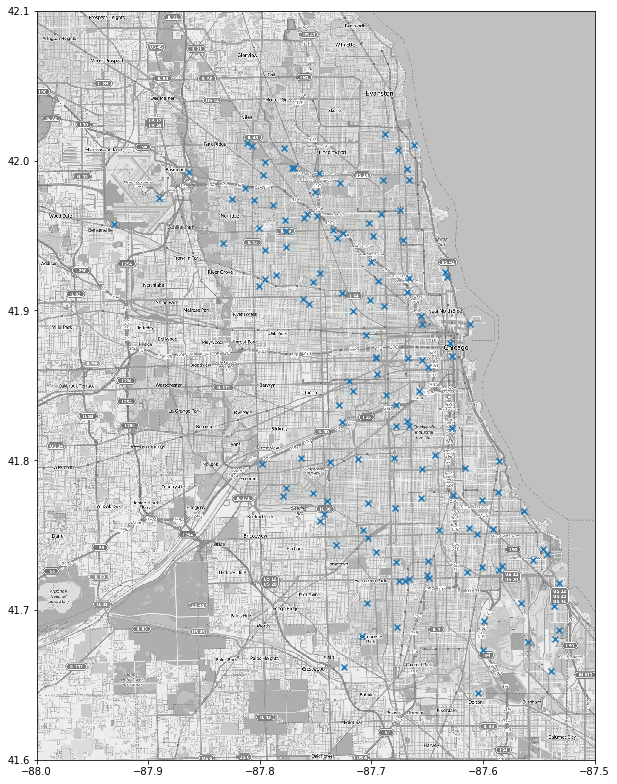

In [2]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

mapdata = np.loadtxt("./input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('./input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

#plt.savefig('heatmap.png')

In [3]:
plt.savefig('heatmap.png')

In [4]:
data = pd.read_csv('./input/train.csv')

### Functions 

In [5]:
from geopy.distance import vincenty

# function to choose weather station 1 or 2
def weather_station(x):
    ohare = (41.995, -87.933)
    midway = (41.786, -87.752)
    # if distance to ohare less than distance to midway, return 1 else return 2
    if vincenty((float(x.split()[0]), float(x.split()[1])), ohare).meters < vincenty((float(x.split()[0]), float(x.split()[1])), midway).meters:
        return 1
    else:
        return 2

In [6]:
#cleans data and does some simple featuring engineering. I did this to clean up the code and make it easy to read
def clean_data(df, test=False):
    
    #convert Date into datetime object, create columns for month, day, and combination of month and day
    df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
    df['month'] = df['Date'].map(lambda x: x.month)
    df['day'] = df['Date'].map(lambda x: x.day)
    df['month_day'] = df['day'].map(lambda x: x/30) + df.month #ex. makes month and day on a numerical scale so end of month is closer to beginning of next month 
    df['year'] = df['Date'].map(lambda x: x.year)
    
    # make 'lat_long' column, and then uses it to map which weather station each trap is closest to. 
    df['lat_long'] = df['Latitude'].astype(str) + ' ' + df['Longitude'].astype(str)
    df['wstation']= df['lat_long'].apply(lambda x: weather_station(x))
    #get rid of lat_long column since its not needed in our final dataframe, 
    #this line can be deleted since were explicitly choosing columns in when we return our final dataframe
    df.drop('lat_long', axis='columns', inplace=True)
    
    #creates a column that multiplies latitude and longitude and rounds it to 3 decimal points
    df['latxlong'] = df['Latitude'] * df['Longitude']
    df['latxlong'] = df['latxlong'].map(lambda x: round(x,3))
    
    #choosing features from train data set that we want in our dataframe before we merge with weather data
    if test==False:
        final_data = df[['Date','Species','Trap','wstation','Latitude','Longitude','latxlong','year','month','day','month_day','WnvPresent']]
        final_data = pd.get_dummies(final_data, columns = ['Species', 'Trap']) #encodes these categorical values 
    else:
        final_data = df[['Date','Species','Trap','wstation','Latitude','Longitude','latxlong','year','month','day','month_day']]
        final_data = pd.get_dummies(final_data, columns = ['Species', 'Trap'])
    return final_data

In [7]:
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score

#if fitting multiple models, have dictionary of 'model name' : model, and loop through to plot AUC ROC curve
def plot_roc(model):
    probas = model.predict_proba(X_test)
    probs = probas[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # method I: plt
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Weather Data Cleaning

In [8]:
weather = pd.read_csv('./input/weather.csv')
pd.options.display.max_columns = 999

In [9]:
# # make raw Codesum values
# raw_codes = weather.CodeSum.unique()

# # make new set of each unique CodeSum in raw_codes
# codes = set()
# for i in raw_codes:
#     for n in range(len(i.split())):
#         codes.add(i.split()[n])

# # remove the one value with a '+'
# codes.remove('FG+')

# function to map dummy variables
def code_dum(code, x):
    if code in x:
        return 1
    else:
        return 0
    

# # make new column for each code and apply dummy variable function to it
# for n in codes:
#     weather[n] = weather['CodeSum'].apply(lambda x: code_dum(n, x))
    
# # drop Codesum column
# weather.drop('CodeSum', axis=1, inplace=True)



In [10]:
def clean_weather(weather):
    weather = weather.drop(labels = ['SnowFall', 'Depart', 'Heat', 'Cool', 'Depth', 'Water1', 'SeaLevel', 'AvgSpeed'], axis=1)
    weather['Date'] = pd.to_datetime(weather['Date'])
    
    weather = weather.drop(labels = ['Tavg'], axis = 1)
    weather = weather[weather.WetBulb != 'M']
    
    weather = weather.replace('-',np.NaN)
    weather.Sunrise = weather.Sunrise.fillna(method='ffill')
    weather.Sunset = weather.Sunset.fillna(method='ffill')
    
    
    weather.PrecipTotal.replace('T', 0.01, inplace=True)
    weather.PrecipTotal.replace('  T', 0.01, inplace=True)
    
    weather = weather[(weather.PrecipTotal != 'M') & (weather.StnPressure != 'M')]
    
    weather.Sunrise = weather.Sunrise.astype(int)/2400
    weather.Sunset = weather.Sunset.astype(int)/2400
    weather.PrecipTotal = weather.PrecipTotal.astype('float64')
    weather.StnPressure = weather.StnPressure.astype('float64')
    weather.WetBulb = weather.WetBulb.astype(int)
    
    # make raw Codesum values
    raw_codes = weather.CodeSum.unique()

    # make new set of each unique CodeSum in raw_codes
    codes = set()
    for i in raw_codes:
        for n in range(len(i.split())):
            codes.add(i.split()[n])

    # remove the one value with a '+'
    codes.remove('FG+')
    
    # make new column for each code and apply dummy variable function to it
    for n in codes:
        weather[n] = weather['CodeSum'].apply(lambda x: code_dum(n, x))
    
    # drop Codesum column
    weather.drop('CodeSum', axis=1, inplace=True)
    
    return weather


In [11]:
weather = clean_weather(weather)

## training data cleaning

In [12]:
final_data = clean_data(data)

In [13]:
pd.options.display.max_columns = 999
final_data.head()

,Date,wstation,Latitude,Longitude,latxlong,year,month,day,month_day,WnvPresent,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,2007-05-29,1,41.954690,-87.800991,-3683.663,2007,5,29,5.966667,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,1,41.954690,-87.800991,-3683.663,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,1,41.994991,-87.769279,-3685.870,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,1,41.974089,-87.824812,-3686.366,2007,5,29,5.966667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,1,41.974089,-87.824812,-3686.366,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## combining Training data and Weather Data

In [14]:
# i have not summed up mosquitos.
### concat/merge weather data

combined_data = pd.merge(final_data, weather, left_on = ['Date', 'wstation'], right_on = ['Date', 'Station'])

In [15]:
len(combined_data), len(final_data)

(10446, 10506)

In [16]:
combined_data.info(max_cols = 999)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10446 entries, 0 to 10445
Data columns (total 179 columns):
Date                              10446 non-null datetime64[ns]
wstation                          10446 non-null int64
Latitude                          10446 non-null float64
Longitude                         10446 non-null float64
latxlong                          10446 non-null float64
year                              10446 non-null int64
month                             10446 non-null int64
day                               10446 non-null int64
month_day                         10446 non-null float64
WnvPresent                        10446 non-null int64
Species_CULEX ERRATICUS           10446 non-null uint8
Species_CULEX PIPIENS             10446 non-null uint8
Species_CULEX PIPIENS/RESTUANS    10446 non-null uint8
Species_CULEX RESTUANS            10446 non-null uint8
Species_CULEX SALINARIUS          10446 non-null uint8
Species_CULEX TARSALIS            10446 non-null

## Exploratory Data Analysis

In [17]:
import seaborn as sns
combined_data.head()

,Date,wstation,Latitude,Longitude,latxlong,year,month,day,month_day,WnvPresent,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Station,Tmax,Tmin,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,ResultSpeed,ResultDir,RA,HZ,DZ,BR,TSRA,TS,BCFG,SQ,SN,GR,FU,MIFG,FG,VCFG,VCTS
0,2007-05-29,1,41.954690,-87.800991,-3683.663,2007,5,29,5.966667,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,60,58,65,0.175417,0.79875,0.0,29.39,5.8,18,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,1,41.954690,-87.800991,-3683.663,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,60,58,65,0.175417,0.79875,0.0,29.39,5.8,18,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,1,41.994991,-87.769279,-3685.870,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,60,58,65,0.175417,0.79875,0.0,29.39,5.8,18,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,1,41.974089,-87.824812,-3686.366,2007,5,29,5.966667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,60,58,65,0.175417,0.79875,0.0,29.39,5.8,18,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,1,41.974089,-87.824812,-3686.366,2007,5,29,5.966667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,60,58,65,0.175417,0.79875,0.0,29.39,5.8,18,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
species_count = pd.DataFrame(data.groupby('Species')['NumMosquitos'].sum().sort_values(ascending = False) )
species_count.reset_index(inplace=True)
species_count

,Species,NumMosquitos
0,CULEX PIPIENS/RESTUANS,66268
1,CULEX PIPIENS,44671
2,CULEX RESTUANS,23431
3,CULEX TERRITANS,510
4,CULEX SALINARIUS,145
5,CULEX TARSALIS,7
6,CULEX ERRATICUS,7


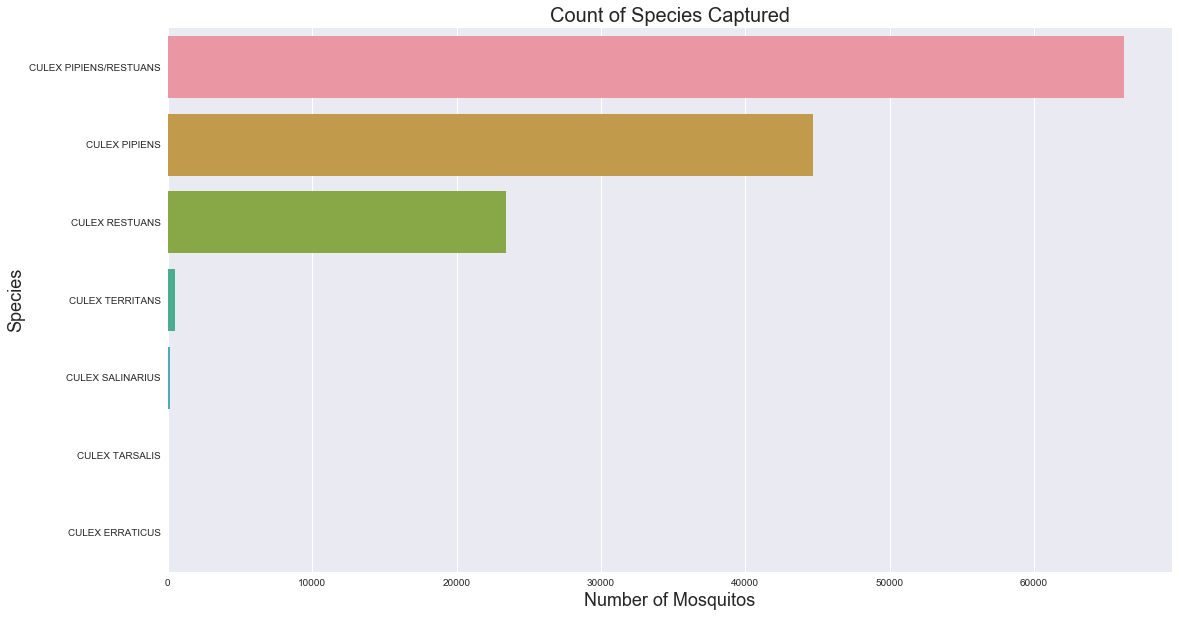

In [19]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.barplot(y='Species', x='NumMosquitos', data=species_count, orient = 'h')
ax.set_xlabel('Number of Mosquitos', fontsize = 18)
ax.set_ylabel('Species', fontsize=18)
ax.set_title('Count of Species Captured', fontsize=20)

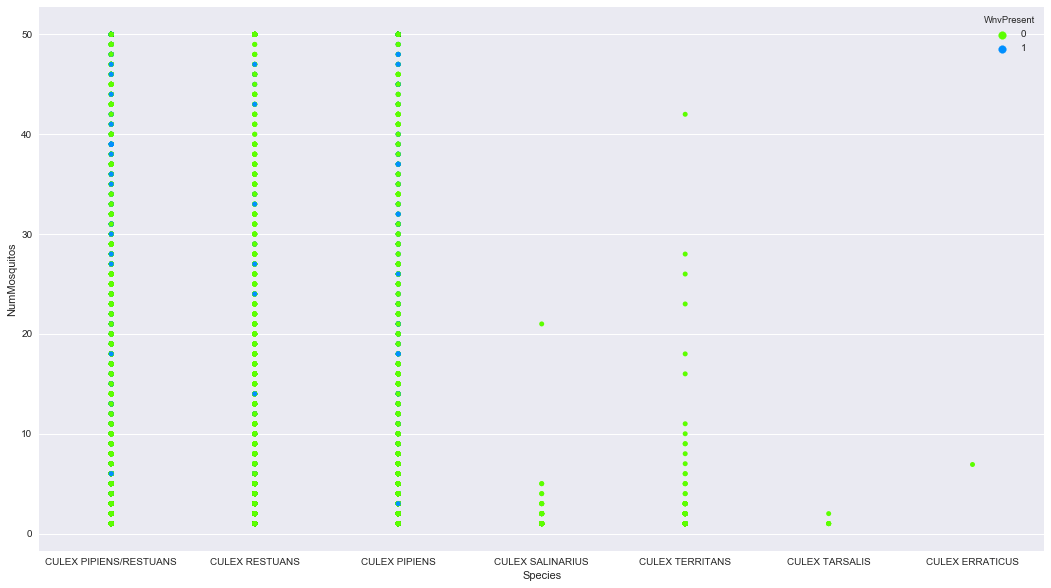

In [20]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.stripplot(x='Species', y='NumMosquitos', data=data, hue = 'WnvPresent', palette='gist_rainbow')

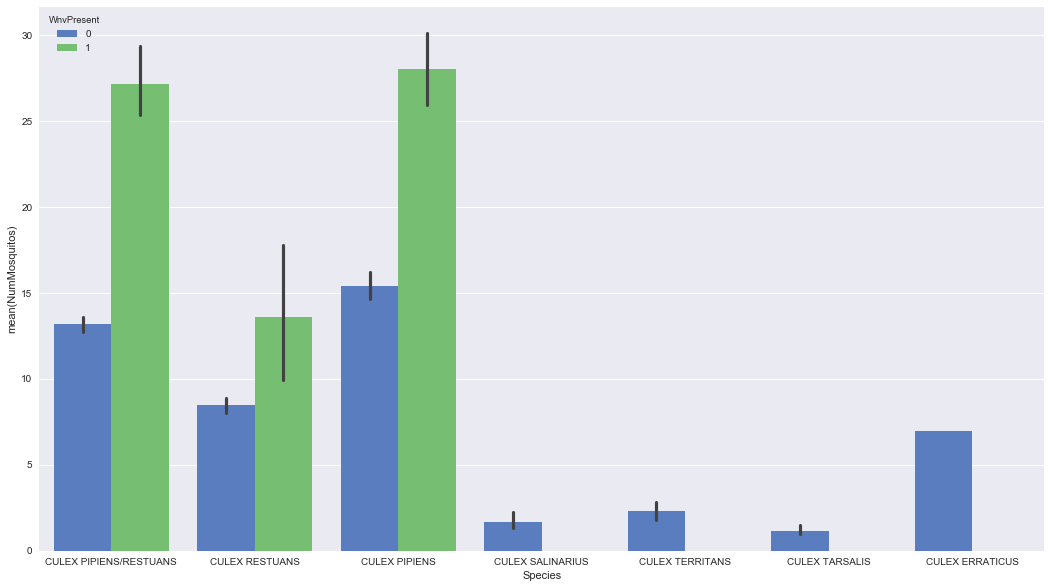

In [21]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.barplot(x='Species', y='NumMosquitos', data=data, hue = 'WnvPresent', palette='muted')

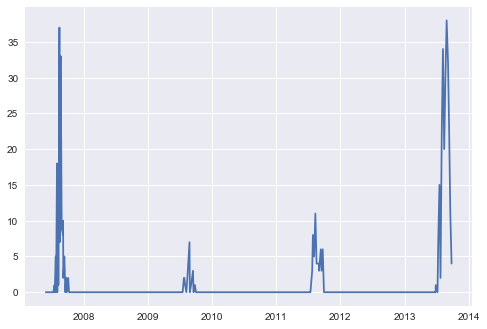

In [22]:
plt.plot(final_data.groupby('Date').WnvPresent.sum())

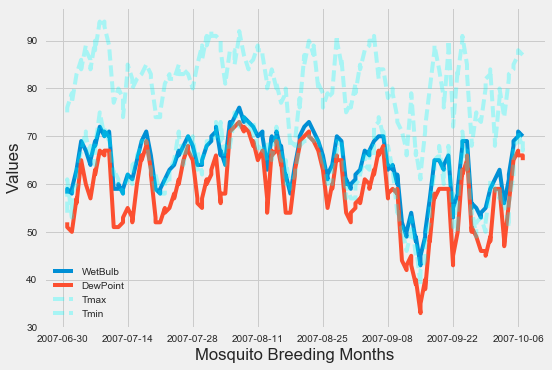

In [23]:
mask = (weather['Date'] >='2007-07-01' ) & (weather['Date'] <='2007-10-07')

plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (10,8))

plt.plot(weather[mask].Date, weather[mask].WetBulb)
plt.plot(weather[mask].Date, weather[mask].DewPoint)
plt.plot(weather[mask].Date, weather[mask].Tmax, c='cyan', ls = '--', alpha = .3)
plt.plot(weather[mask].Date, weather[mask].Tmin, c='cyan', ls = '--', alpha = .3)
plt.legend()
plt.xlabel('Mosquito Breeding Months')
plt.ylabel('Values')

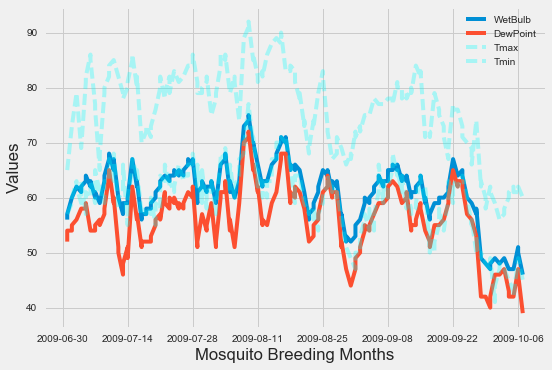

In [24]:
mask = (weather['Date'] >='2009-07-01' ) & (weather['Date'] <='2009-10-07')

plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (10,8))

plt.plot(weather[mask].Date, weather[mask].WetBulb)
plt.plot(weather[mask].Date, weather[mask].DewPoint)
plt.plot(weather[mask].Date, weather[mask].Tmax, c='cyan', ls = '--', alpha = .3)
plt.plot(weather[mask].Date, weather[mask].Tmin, c='cyan', ls = '--', alpha = .3)
plt.legend()
plt.xlabel('Mosquito Breeding Months')
plt.ylabel('Values')

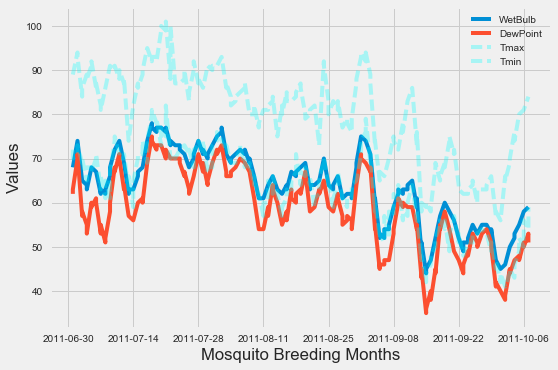

In [25]:
mask = (weather['Date'] >='2011-07-01' ) & (weather['Date'] <='2011-10-07')

plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (10,8))

plt.plot(weather[mask].Date, weather[mask].WetBulb)
plt.plot(weather[mask].Date, weather[mask].DewPoint)
plt.plot(weather[mask].Date, weather[mask].Tmax, c='cyan', ls = '--', alpha = .3)
plt.plot(weather[mask].Date, weather[mask].Tmin, c='cyan', ls = '--', alpha = .3)
plt.legend()
plt.xlabel('Mosquito Breeding Months')
plt.ylabel('Values')

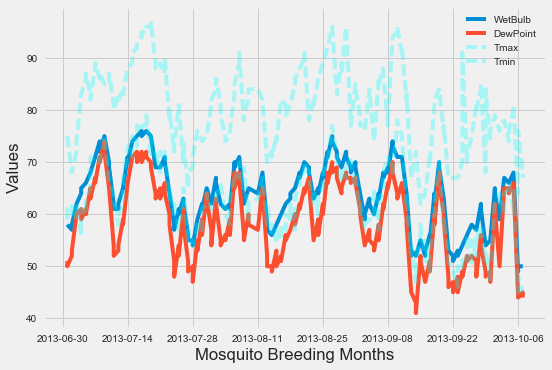

In [26]:
mask = (weather['Date'] >='2013-07-01' ) & (weather['Date'] <='2013-10-07')

plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (10,8))

plt.plot(weather[mask].Date, weather[mask].WetBulb)
plt.plot(weather[mask].Date, weather[mask].DewPoint)
plt.plot(weather[mask].Date, weather[mask].Tmax, c='cyan', ls = '--', alpha = .3)
plt.plot(weather[mask].Date, weather[mask].Tmin, c='cyan', ls = '--', alpha = .3)
plt.legend()
plt.xlabel('Mosquito Breeding Months')
plt.ylabel('Values')

## modeling fun

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split


rf = RandomForestClassifier(n_jobs=-1, n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(combined_data.drop(labels = ['Date', 'WnvPresent'], axis=1),
                                                    combined_data['WnvPresent'],
                                                    test_size = .25,
                                                    random_state = 42)

y_train.head()

1487    0
4081    0
180     0
6152    0
2115    0
Name: WnvPresent, dtype: int64

In [29]:
#oversampling on training data only, to prevent leakage to testing data.
sm = SMOTE(random_state=42, ratio = 'minority')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [30]:
rf.fit(X_train_res, y_train_res)
rf.score(X_test, y_test) #but score accuracy doesn't tell the whole story, we want sensitivity aka recall

0.9341500765696784

In [31]:
from sklearn.metrics import recall_score
y_pred = rf.predict(X_test)
recall_score(y_test, y_pred)

0.23134328358208955

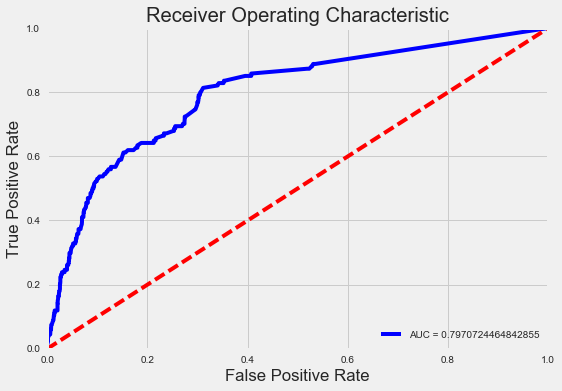

In [32]:
plot_roc(rf)

In [33]:
important_features = pd.Series(data=rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features

Sunset                            7.325517e-02
Sunrise                           6.780822e-02
Species_CULEX PIPIENS             6.455934e-02
Species_CULEX PIPIENS/RESTUANS    5.858411e-02
Species_CULEX RESTUANS            5.493200e-02
month_day                         5.285835e-02
month                             5.127980e-02
Longitude                         4.450369e-02
latxlong                          4.100570e-02
Latitude                          3.975711e-02
year                              3.383092e-02
DewPoint                          2.582964e-02
ResultSpeed                       2.578113e-02
WetBulb                           2.564634e-02
Tmax                              2.348314e-02
StnPressure                       2.052464e-02
Tmin                              1.993852e-02
day                               1.992336e-02
ResultDir                         1.647469e-02
PrecipTotal                       1.087856e-02
BR                                8.973251e-03
Trap_T900    

In [34]:
features = list(important_features[:20].index)

In [35]:
print(features)

['Sunset', 'Sunrise', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'month_day', 'month', 'Longitude', 'latxlong', 'Latitude', 'year', 'DewPoint', 'ResultSpeed', 'WetBulb', 'Tmax', 'StnPressure', 'Tmin', 'day', 'ResultDir', 'PrecipTotal']


In [36]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(combined_data[features],
                                                    combined_data['WnvPresent'],
                                                    test_size = .25,
                                                    random_state = 42)
            
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

recall_score(y_test, y_pred)

0.2835820895522388

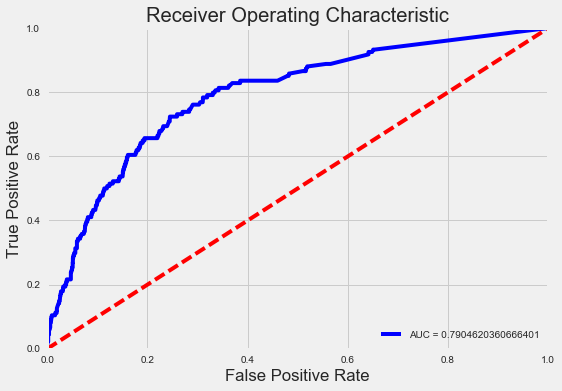

In [37]:
plot_roc(rf)

In [40]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,2351,127
1,96,38


In [42]:
confusion_matrix(y_test, y_pred)

array([[2351,  127],
       [  96,   38]], dtype=int64)

In [41]:
# adjusting plot_roc for neural net
def plot_roc_nn(y_true, probs):
    
    fpr, tpr, threshold = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    
    # method I: plt
    # import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic', fontsize=18)
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.show()

In [42]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [43]:
# scale X data
ss = StandardScaler()
X_train_nn = ss.fit_transform(X_train_res)
X_test_nn = ss.transform(X_test)

y_train_nn = y_train_res

In [44]:
# initialize model
model = Sequential()

# layer sizes
n_input = X_train_nn.shape[1]
n_hidden = 20

# input and first hidden layer
model.add(Dense(n_hidden, input_dim=n_input, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# dropout layer
model.add(Dropout(0.5))

# second hidden layer
model.add(Dense(n_hidden, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# dropout layer
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation='sigmoid'))

# select learning rate
adam = Adam(lr=0.001)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# save model output as hist
hist = model.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test), epochs=50, batch_size=256)

Train on 14834 samples, validate on 2612 samples
Epoch 1/50
14834/14834 [==============================] - 1s 52us/step - loss: 1.0657 - binary_accuracy: 0.5334 - val_loss: 0.8685 - val_binary_accuracy: 0.6757
Epoch 2/50
14834/14834 [==============================] - 0s 9us/step - loss: 0.9065 - binary_accuracy: 0.6068 - val_loss: 0.7696 - val_binary_accuracy: 0.6497
Epoch 3/50
14834/14834 [==============================] - 0s 10us/step - loss: 0.8161 - binary_accuracy: 0.6473 - val_loss: 0.7052 - val_binary_accuracy: 0.6401
Epoch 4/50
14834/14834 [==============================] - 0s 14us/step - loss: 0.7484 - binary_accuracy: 0.6830 - val_loss: 0.6518 - val_binary_accuracy: 0.6470
Epoch 5/50
14834/14834 [==============================] - 0s 14us/step - loss: 0.6955 - binary_accuracy: 0.7018 - val_loss: 0.6137 - val_binary_accuracy: 0.6669
Epoch 6/50
14834/14834 [==============================] - 0s 11us/step - loss: 0.6534 - binary_accuracy: 0.7241 - val_loss: 0.5875 - val_binary_acc

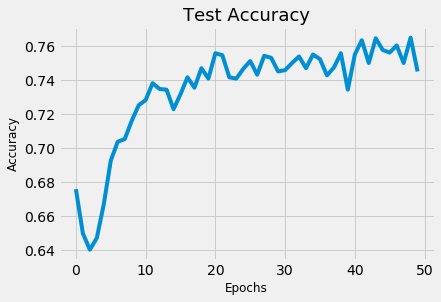

In [45]:
# plot accuracy learning curve
plt.plot(hist.history['val_binary_accuracy'])
plt.title('Test Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12);

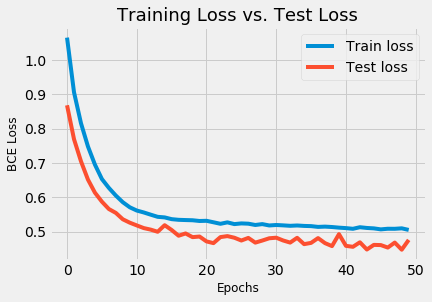

In [46]:
# plot loss learning curves
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.title('Training Loss vs. Test Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('BCE Loss', fontsize=12)
plt.legend();

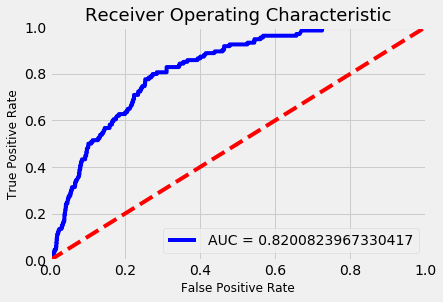

In [47]:
probs = model.predict(X_test_nn)
plot_roc_nn(y_test, probs)

## Kaggle Predictions on Kaggle test data

In [102]:
test_data = pd.read_csv('./input/test.csv')
test_data = clean_data(test_data, test=True)
test_combined_data = pd.merge(test_data, weather, left_on = ['Date', 'wstation'], right_on = ['Date', 'Station'])

In [145]:
sample = pd.read_csv('./input/sampleSubmission.csv')
#writing the probabilites to a csv named sample.csv , really just overwriting the sample submission csv
probs = rf.predict_proba(test_combined_data[features])[:,1]
sample['WnvPresent'] = probs
sample.to_csv('probs.csv', index=False)

In [ ]:
# submission 2
x_final = test_combined_data[features]

ss = StandardScaler()
x_final_scaled = ss.fit_transform(x_final)

probs = model.predict(x_final_scaled)
sample['WnvPresent'] = probs
sample.to_csv('kaggle_predictions_2.csv', index=False)